In [4]:
import os
from PIL import Image
import numpy as np
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, concatenate
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from kerastuner import HyperModel, Hyperband
import json

In [8]:
def load_and_resize_images(base_dir, size=(224, 224)):
    image_data = []
    labels = []

    # Vérifier si le dossier existe bien
    if not os.path.exists(base_dir):
        raise ValueError(f"Le dossier spécifié n'existe pas: {base_dir}")
    
    # Parcourir chaque fichier dans le dossier
    for filename in os.listdir(base_dir):
        if filename.endswith('.jpg'):
            # Construire le chemin complet vers l'image
            file_path = os.path.join(base_dir, filename)
            
            # Extraire les étiquettes à partir du nom de fichier
            label_parts = filename.split('_')
            # S'assurer que le fichier a un format de nom correct avant de continuer
            if len(label_parts) != 4 or not all(part.isdigit() for part in label_parts[:3]):
                print(f"Ignorer le fichier non conforme: {filename}")
                continue  # Ignorer ce fichier et passer au suivant
            
            # Charger l'image et la redimensionner
            try:
                image = Image.open(file_path).convert('RGB')
                image = image.resize(size)
            except Exception as e:
                print(f"Impossible de traiter l'image {filename}: {e}")
                continue  # Ignorer ce fichier et passer au suivant

            # Convertir l'image en un tableau numpy et l'ajouter à la liste
            image_np = np.array(image)
            image_data.append(image_np)

            labels.append({
                'age': int(label_parts[0]),
                'gender': int(label_parts[1]),
                'race': int(label_parts[2]),
                'date&time': label_parts[3].split('.')[0] 
            })
            
            # Fermer l'image pour libérer de la mémoire
            image.close()

    return np.array(image_data), labels

In [9]:
class VGG16HyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=self.input_shape))
        for layer in base_model.layers:
            layer.trainable = False

        x = Flatten()(base_model.output)
        for i in range(hp.Int('num_layers', 1, 3)):  # Nombre de couches denses ajoutées
            x = Dense(
                units=hp.Int(f'units_{i}', min_value=128, max_value=1024, step=128),
                activation='relu',
                kernel_regularizer=keras.regularizers.l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-1, sampling='log'))
            )(x)
            x = Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05))(x)
        age_output = Dense(1, activation='linear')(x)

        model = Model(inputs=base_model.input, outputs=age_output)

        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )

        return model

input_shape = (224, 224, 3)
hypermodel = VGG16HyperModel(input_shape=input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_mae',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='vgg16_age_prediction'
)

early_stopping = EarlyStopping(monitor='val_mae', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_mae', mode='min')

images1, image_labels1 = load_and_resize_images('part1_bis')
images2, image_labels2 = load_and_resize_images('part2_bis')
images3, image_labels3 = load_and_resize_images('part3_bis')

# Concaténer les tableaux d'images
images_concat = np.concatenate((images1, images2, images3), axis=0)

# Pour obtenir les étiquettes d'âge, il faut extraire les âges de labels_concat
ages = np.array([label['age'] for label in (image_labels1 + image_labels2 + image_labels3)])

tuner.search(
    images_concat, ages,
    validation_split=0.2,
    callbacks=[early_stopping, mcp_save]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Sauvegarder les hyperparamètres dans un fichier JSON
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters.values, f)

print(f"Meilleurs hyperparamètres: {best_hyperparameters.values}")


Trial 30 Complete [02h 01m 04s]
val_mae: 9.248418807983398

Best val_mae So Far: 9.067401885986328
Total elapsed time: 1d 14h 35m 26s
Meilleurs hyperparamètres: {'num_layers': 2, 'units_0': 896, 'l2_reg': 0.054648614949158396, 'dropout': 0.2, 'learning_rate': 0.0006270538867968894, 'units_1': 128, 'units_2': 128, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [13]:
# Reconstruire le modèle avec les meilleurs hyperparamètres
def build_model_with_hyperparameters(hyperparams, input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False

    x = Flatten()(base_model.output)
    for i in range(hyperparams['num_layers']):
        x = Dense(
            units=hyperparams[f'units_{i}'],
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(hyperparams['l2_reg'])
        )(x)
        x = Dropout(rate=hyperparams['dropout'])(x)
    age_output = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=age_output)
    model.compile(
        optimizer=Adam(learning_rate=hyperparams['learning_rate']),
        loss='mse',
        metrics=['mae']
    )

    return model


Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - loss: 1098.4270 - mae: 17.2373 - val_loss: 269.8531 - val_mae: 9.4959
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - loss: 249.2376 - mae: 9.6018 - val_loss: 260.4554 - val_mae: 9.4053
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - loss: 218.1890 - mae: 8.7269 - val_loss: 254.3667 - val_mae: 8.9085
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1537s 3s/step - loss: 190.2170 - mae: 7.7906 - val_loss: 252.7401 - val_mae: 9.2103
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1427s 3s/step - loss: 183.9558 - mae: 7.6412 - val_loss: 258.7859 - val_mae: 8.9677
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1169s 2s/step - loss: 171.7909 - mae: 7.2509 - val_loss: 247.9104 - val_mae: 8.8293
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - loss: 164.5921 - mae: 7.1191 - val_loss: 254.7027 - val_mae: 9.3663
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1061s 2s/step - loss: 159.3095 - mae: 6.9645 - val_loss: 237.3573 - val_mae: 8.7358
Epoch 9/1

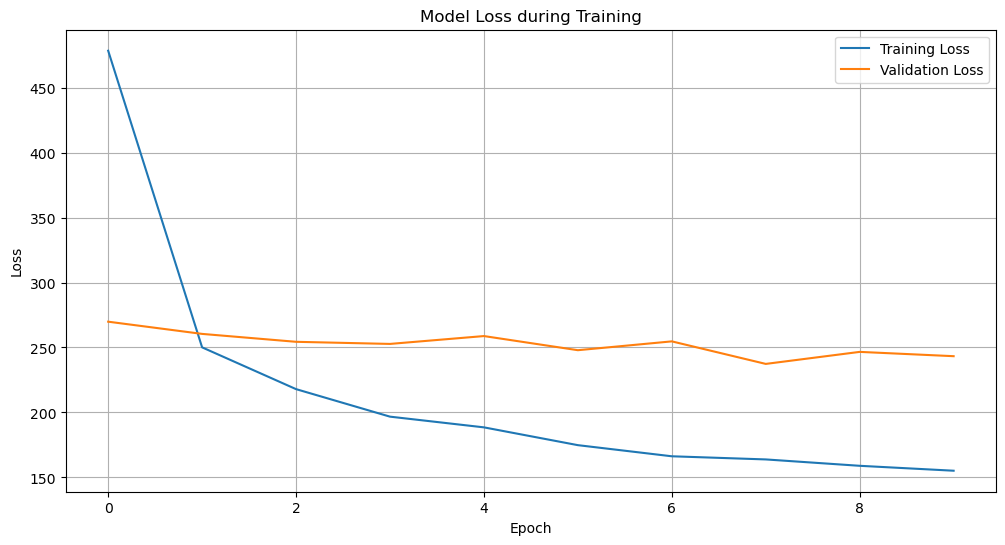

142/142 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - loss: 216.9628 - mae: 8.3249
Test MAE: 8.594801902770996
142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step


In [14]:
from sklearn.model_selection import train_test_split
from keras.models import load_model
import json
import matplotlib.pyplot as plt

# Séparation des ensembles de données
images_train, images_test, ages_train, ages_test = train_test_split(
    images_concat, 
    ages, 
    test_size=0.2,    # Par exemple 20% pour le test
    random_state=42,  # Pour la reproductibilité
    #stratify=ages     # Pour une distribution uniforme des tranches d'âge
)

# Reconstruis le modèle avec les meilleurs hyperparamètres
best_model = build_model_with_hyperparameters(best_hyperparameters, input_shape=(224, 224, 3))

# Entraîne le modèle avec l'ensemble d'entraînement et enregistre l'historique
history = best_model.fit(
    images_train, 
    ages_train, 
    validation_split=0.1,  # Tu peux utiliser une partie de l'entraînement pour la validation
    epochs=10,             # Le nombre d'époques peut être déterminé selon tes besoins
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)]
)

# Tracer les graphiques de la perte pour l'entraînement et la validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Évalue le modèle sur l'ensemble de test
test_loss, test_mae = best_model.evaluate(images_test, ages_test)
print(f"Test MAE: {test_mae}")

# Tu peux maintenant faire des prédictions sur images_test et comparer avec ages_test pour obtenir l'erreur par tranche d'âge
predicted_ages = best_model.predict(images_test)


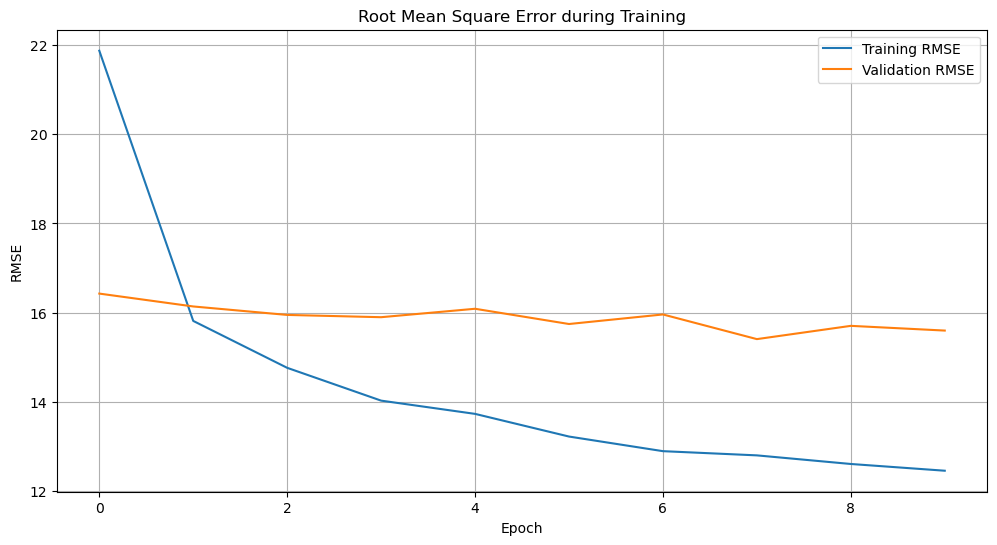

In [69]:
# Exemple: history.history['loss'], history.history['val_loss'], etc.
mse_train_loss = np.random.randn(10)  # exemple de données
mse_val_loss = np.random.randn(10)  # exemple de données
mae_train = np.random.randn(10)  # exemple de données
mae_val = np.random.randn(10)  # exemple de données

# Calcul de la RMSE à partir des pertes MSE
rmse_train = np.sqrt(mse_train_loss)
rmse_val = np.sqrt(mse_val_loss)

# Tracé du graphique RMSE
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(rmse_train, label='Training RMSE')
plt.plot(rmse_val, label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# Tracé du graphique MAE
plt.subplot(1, 2, 2)
plt.plot(mae_train, label='Training MAE')
plt.plot(mae_val, label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


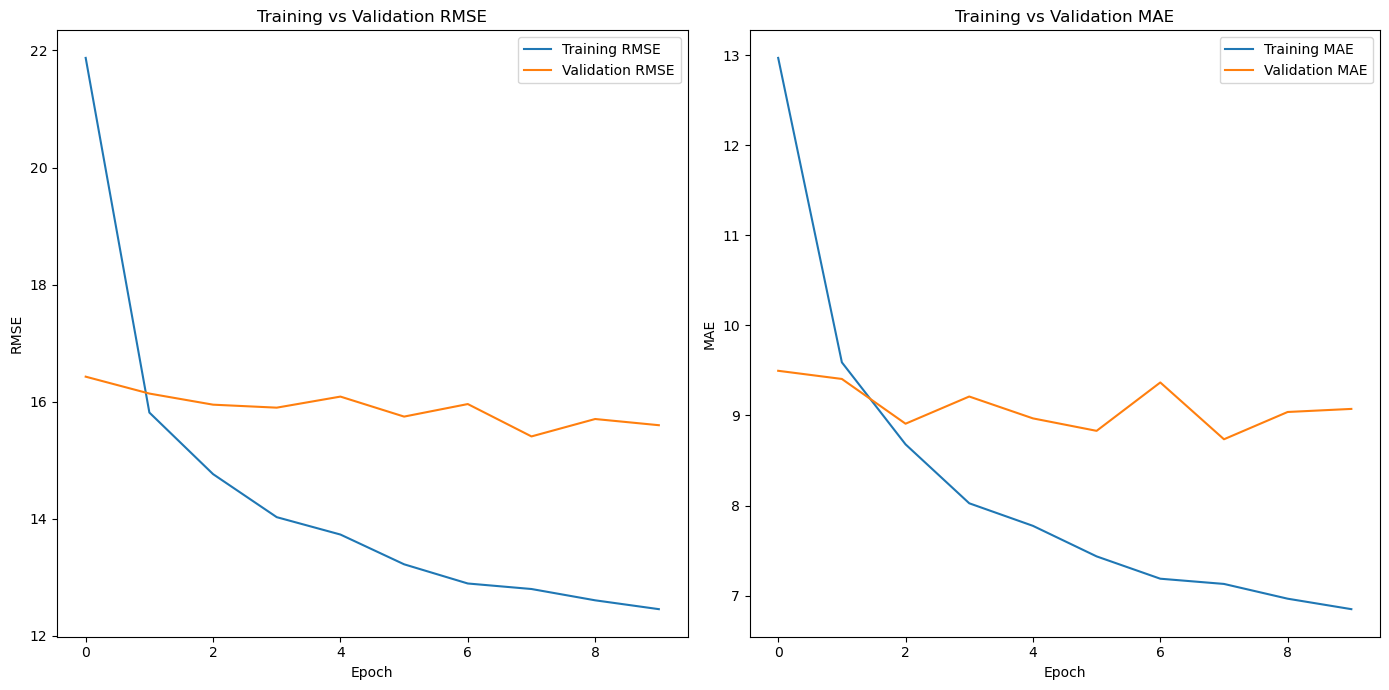

In [70]:
# Calcul du RMSE à partir de l'historique des pertes MSE
train_rmse = np.sqrt(np.array(history.history['loss']))
val_rmse = np.sqrt(np.array(history.history['val_loss']))

# Utilisation directe des valeurs MAE de l'historique
train_mae = np.array(history.history['mae'])
val_mae = np.array(history.history['val_mae'])

# Tracé des graphiques RMSE et MAE
plt.figure(figsize=(14, 7))

# Sous-graphique pour RMSE
plt.subplot(1, 2, 1)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# Sous-graphique pour MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Calcule l'erreur absolue pour chaque prédiction
absolute_errors = np.abs(ages_test - predicted_ages.squeeze())  # Utilise squeeze pour ajuster les dimensions si nécessaire

# Regroupe les erreurs par tranches d'âge et calcule le taux d'erreur
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Exemple de tranches d'âge
error_rates = {}
for start_age, end_age in zip(age_bins[:-1], age_bins[1:]):
    indices = (ages_test >= start_age) & (ages_test < end_age)
    error_rates[f"{start_age}-{end_age}"] = np.mean(absolute_errors[indices]) if np.any(indices) else None

# Affiche le taux d'erreur par tranche d'âge
for age_range, error_rate in error_rates.items():
    print(f"Erreur moyenne pour la tranche d'âge {age_range}: {error_rate}")


Erreur moyenne pour la tranche d'âge 0-10: 6.248020128023867
Erreur moyenne pour la tranche d'âge 10-20: 8.454515455610158
Erreur moyenne pour la tranche d'âge 20-30: 6.034084368127001
Erreur moyenne pour la tranche d'âge 30-40: 6.68820325652988
Erreur moyenne pour la tranche d'âge 40-50: 8.897504802113593
Erreur moyenne pour la tranche d'âge 50-60: 12.767632573716185
Erreur moyenne pour la tranche d'âge 60-70: 13.641261098686785
Erreur moyenne pour la tranche d'âge 70-80: 19.602847063451783
Erreur moyenne pour la tranche d'âge 80-90: 23.94260775105337
Erreur moyenne pour la tranche d'âge 90-100: 37.12162113189697


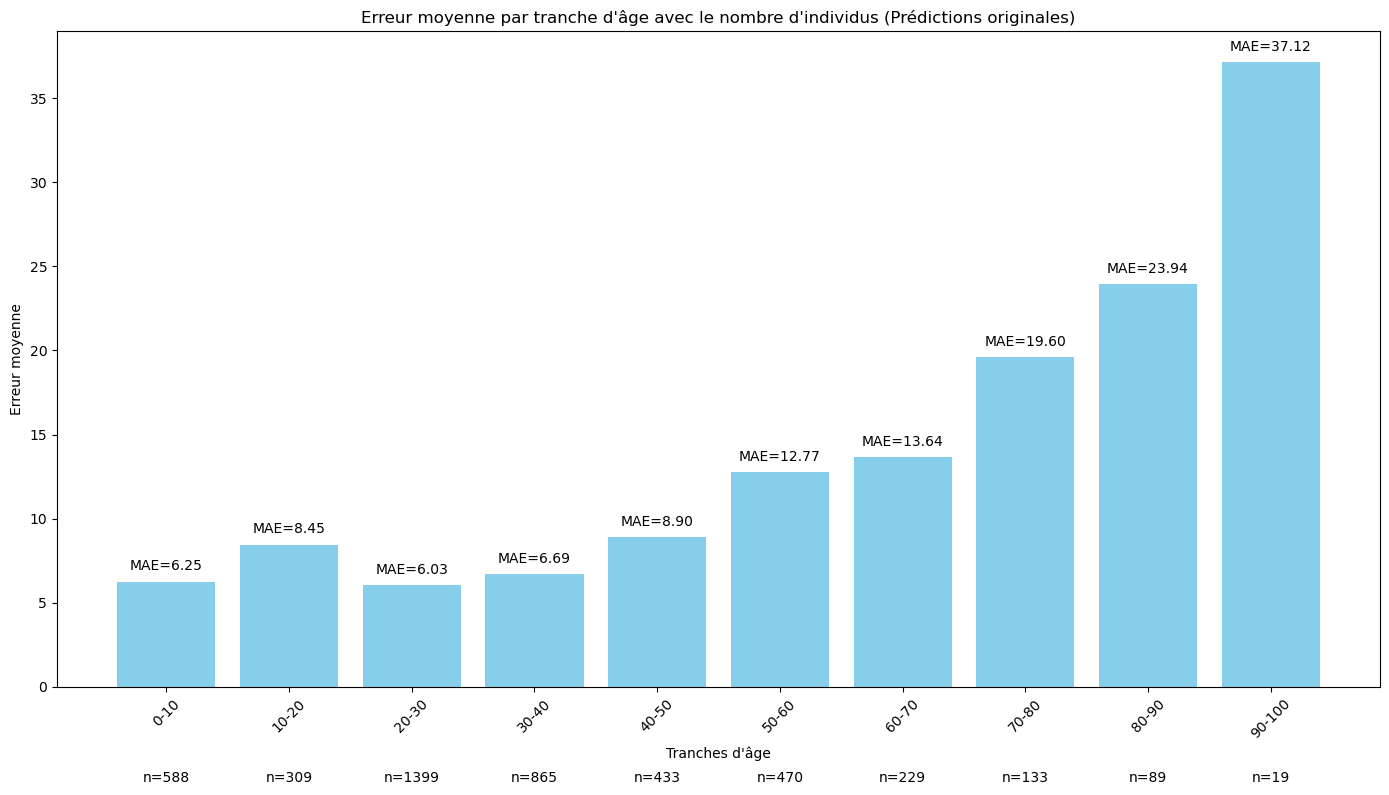

In [63]:
# Calculer le nombre d'individus dans chaque tranche d'âge
age_counts = np.histogram(ages_test, bins=age_bins)[0]

# Convertir les tranches d'âge et les erreurs en listes pour le tracé
age_ranges = [f"{start}-{end}" for start, end in zip(age_bins[:-1], age_bins[1:])]
errors = list(error_rates.values())

# Créer le barplot
plt.figure(figsize=(14, 8))
bars = plt.bar(age_ranges, errors, color='skyblue')

# Ajouter le nombre d'individus sous les barres
for bar, count in zip(bars, age_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, -5, f'n={count}', ha='center', va='top', color='black')

# Ajouter le MAE moyen au-dessus de chaque barre
for bar, error in zip(bars, errors):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'MAE={error:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('Tranches d\'âge')
plt.ylabel('Erreur moyenne')
plt.title('Erreur moyenne par tranche d\'âge avec le nombre d\'individus (Prédictions originales)')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()



In [26]:
# Concatène les étiquettes de toutes les images, y compris l'âge, le genre et l'ethnie
labels_concat = image_labels1 + image_labels2 + image_labels3

# Extrait les étiquettes d'âge et d'ethnie
ages = np.array([label['age'] for label in labels_concat])
genders = np.array([label['gender'] for label in labels_concat])
ethnicities = np.array([label['race'] for label in labels_concat])  # 'race' utilisé ici comme dans ton système de labels

# Maintenant, effectue le train_test_split tout en gardant les mêmes indices pour l'âge, le genre et l'ethnie
images_train, images_test, ages_train, ages_test, genders_train, genders_test, ethnicities_train, ethnicities_test = train_test_split(
    images_concat, 
    ages, 
    genders,
    ethnicities,
    test_size=0.2,
    random_state=42
)

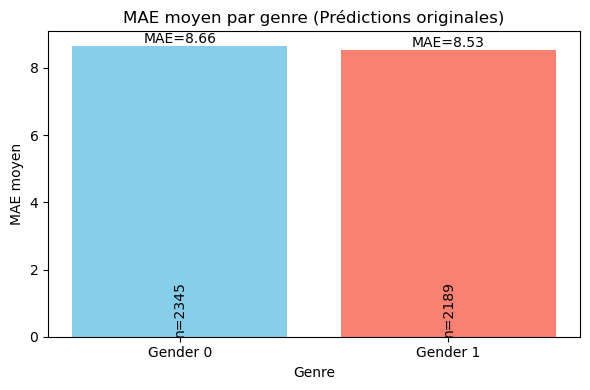

In [60]:
# Calcule le MAE pour chaque genre
unique_genders = np.unique(genders_test)
mae_per_gender = {}
for gender in unique_genders:
    indices = genders_test == gender
    errors = np.abs(ages_test[indices] - predicted_ages[indices].squeeze())  # Utiliser squeeze si les dimensions ne correspondent pas
    mae_per_gender[gender] = np.mean(errors)

# Calcule le nombre d'individus par genre pour l'annotation
counts_per_gender = np.array([(genders_test == g).sum() for g in unique_genders])

# Convertir les données en listes pour le tracé
gender_labels = ['Gender 0', 'Gender 1']  # Remplacer par des noms réels si disponibles
mae_values = list(mae_per_gender.values())

# Créer le barplot
plt.figure(figsize=(6, 4))
bars = plt.bar(gender_labels, mae_values, color=['skyblue', 'salmon'])

# Ajouter le nombre d'individus par genre sous les barres
for bar, count in zip(bars, counts_per_gender):
    plt.text(bar.get_x() + bar.get_width() / 2, 0, f'n={count}', ha='center', va='bottom', color='black', rotation=90)

# Ajouter le MAE moyen au-dessus de chaque barre
for bar, mae in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, mae, f'MAE={mae:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('Genre')
plt.ylabel('MAE moyen')
plt.title('MAE moyen par genre (Prédictions originales)')
plt.tight_layout()
plt.show()


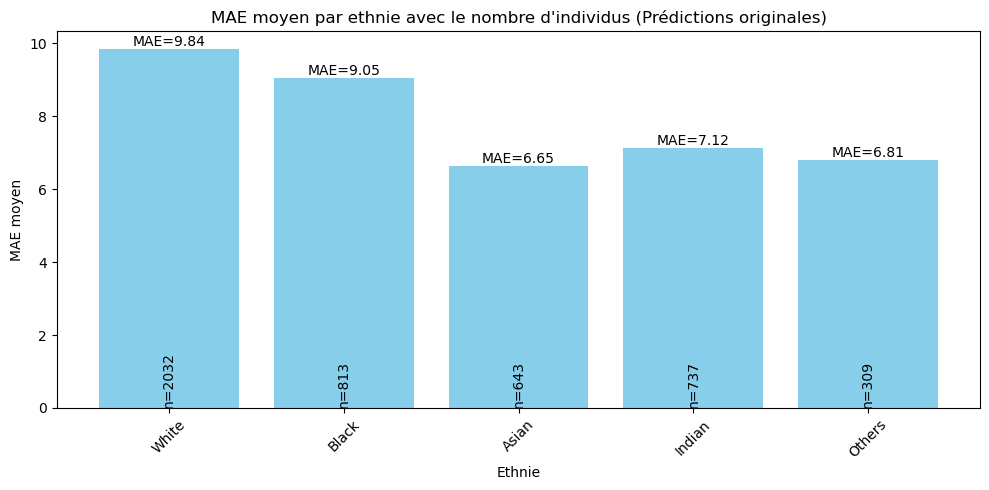

In [59]:
# Supposons que 'predicted_ages' et 'ethnicities_test' sont déjà définis et que 'ethnicities_test' contient les étiquettes d'ethnie pour l'ensemble de test
# Dictionnaire pour renommer les valeurs d'ethnie
ethnicity_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Calcule le MAE pour chaque ethnie
unique_ethnicities = np.unique(ethnicities_test)
mae_per_ethnicity = {}

for ethnicity in unique_ethnicities:
    indices = ethnicities_test == ethnicity
    errors = np.abs(ages_test[indices] - predicted_ages[indices].squeeze())  # Utiliser squeeze si les dimensions ne correspondent pas
    mae_per_ethnicity[ethnicity] = np.mean(errors)

# Calcule le nombre d'individus par ethnie pour l'annotation
counts_per_ethnicity = np.array([(ethnicities_test == e).sum() for e in unique_ethnicities])

# Convertir les données en listes pour le tracé
mae_values = list(mae_per_ethnicity.values())

# Créer le barplot
plt.figure(figsize=(10, 5))
bars = plt.bar([ethnicity_labels[e] for e in unique_ethnicities], [mae_per_ethnicity[e] for e in unique_ethnicities], color='skyblue')

# Ajouter le nombre d'individus par ethnie sous les barres
for bar, count in zip(bars, counts_per_ethnicity):
    plt.text(bar.get_x() + bar.get_width() / 2, 0, f'n={count}', ha='center', va='bottom', color='black', rotation=90)

# Ajouter le MAE moyen au-dessus de chaque barre
for bar, mae in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, mae, f'MAE={mae:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('Ethnie')
plt.ylabel('MAE moyen')
plt.title('MAE moyen par ethnie avec le nombre d\'individus (Prédictions originales)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


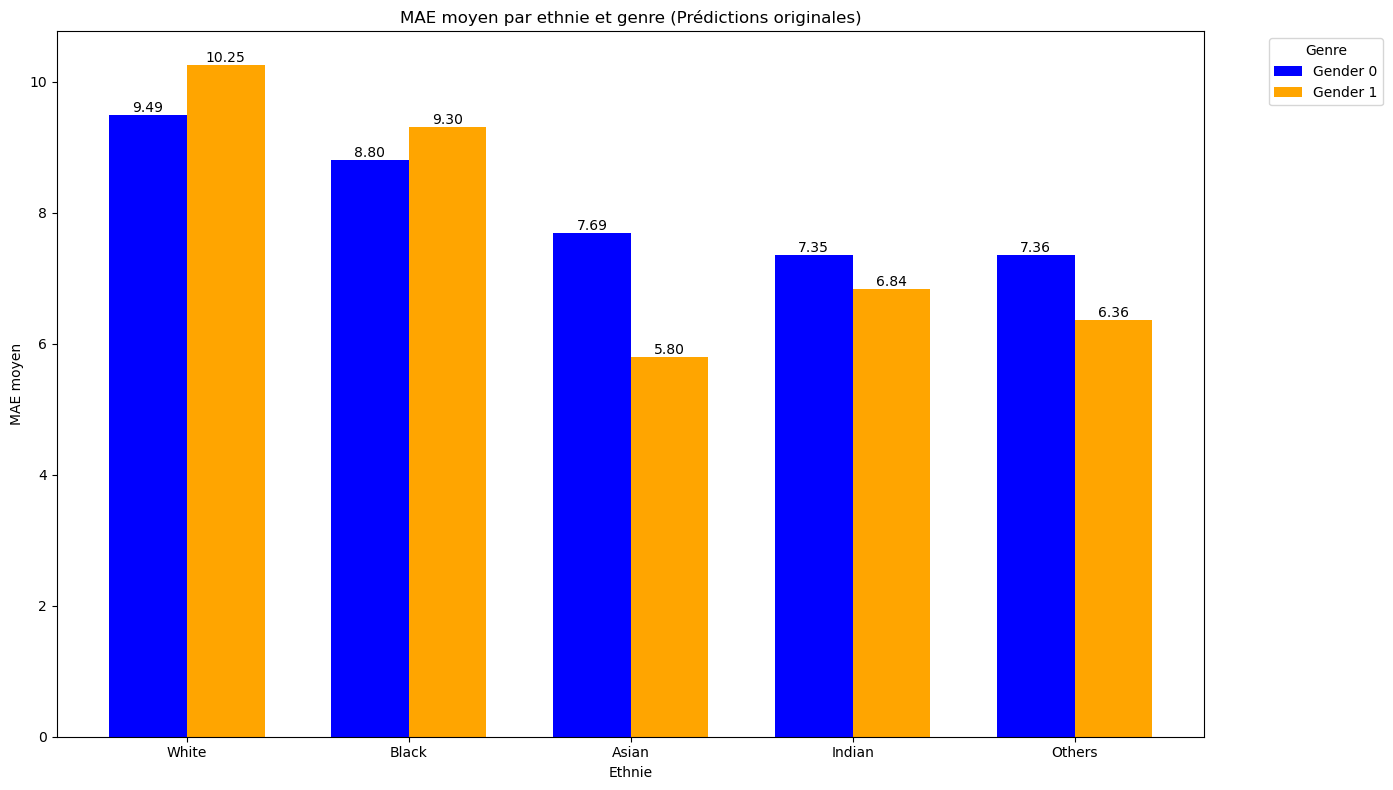

In [58]:
# Définition des étiquettes pour les ethnies
ethnicity_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Calcule le MAE pour chaque combinaison d'ethnie et de genre
unique_ethnicities = np.unique(ethnicities_test)
unique_genders = np.unique(genders_test)
mae_per_ethnicity_gender = {}
for ethnicity in unique_ethnicities:
    mae_per_ethnicity_gender[ethnicity] = {}
    for gender in unique_genders:
        indices = (ethnicities_test == ethnicity) & (genders_test == gender)
        errors = np.abs(ages_test[indices] - predicted_ages[indices].squeeze())
        mae_per_ethnicity_gender[ethnicity][gender] = np.mean(errors) if np.any(indices) else np.nan  # Gestion des NaN

# Préparation des positions sur l'axe des abscisses pour chaque groupe d'ethnie
bar_width = 0.35
ethnicity_positions = np.arange(len(unique_ethnicities))

# Création du graphique à barres
fig, ax = plt.subplots(figsize=(14, 8))

# Ajout des barres pour chaque ethnie et genre
for i, ethnicity in enumerate(unique_ethnicities):
    for j, gender in enumerate(unique_genders):
        position = ethnicity_positions[i] + (j - 0.5) * bar_width
        mae = mae_per_ethnicity_gender[ethnicity][gender]
        ax.bar(position, mae, bar_width, label=f'Gender {gender}' if i == 0 else "", color='blue' if gender == 0 else 'orange')
        if not np.isnan(mae):  # Vérifie que MAE n'est pas NaN avant de l'afficher
            ax.text(position, mae, f'{mae:.2f}', ha='center', va='bottom')

# Configuration des étiquettes et des titres
ax.set_xlabel('Ethnie')
ax.set_ylabel('MAE moyen')
ax.set_title('MAE moyen par ethnie et genre (Prédictions originales)')
ax.set_xticks(ethnicity_positions)
ax.set_xticklabels([ethnicity_labels[e] for e in unique_ethnicities])
ax.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')  # Déplace la légende en dehors du graphique

# Affichage du graphique
plt.tight_layout()  # Ajustement de la mise en page pour éviter le recouvrement
plt.show()


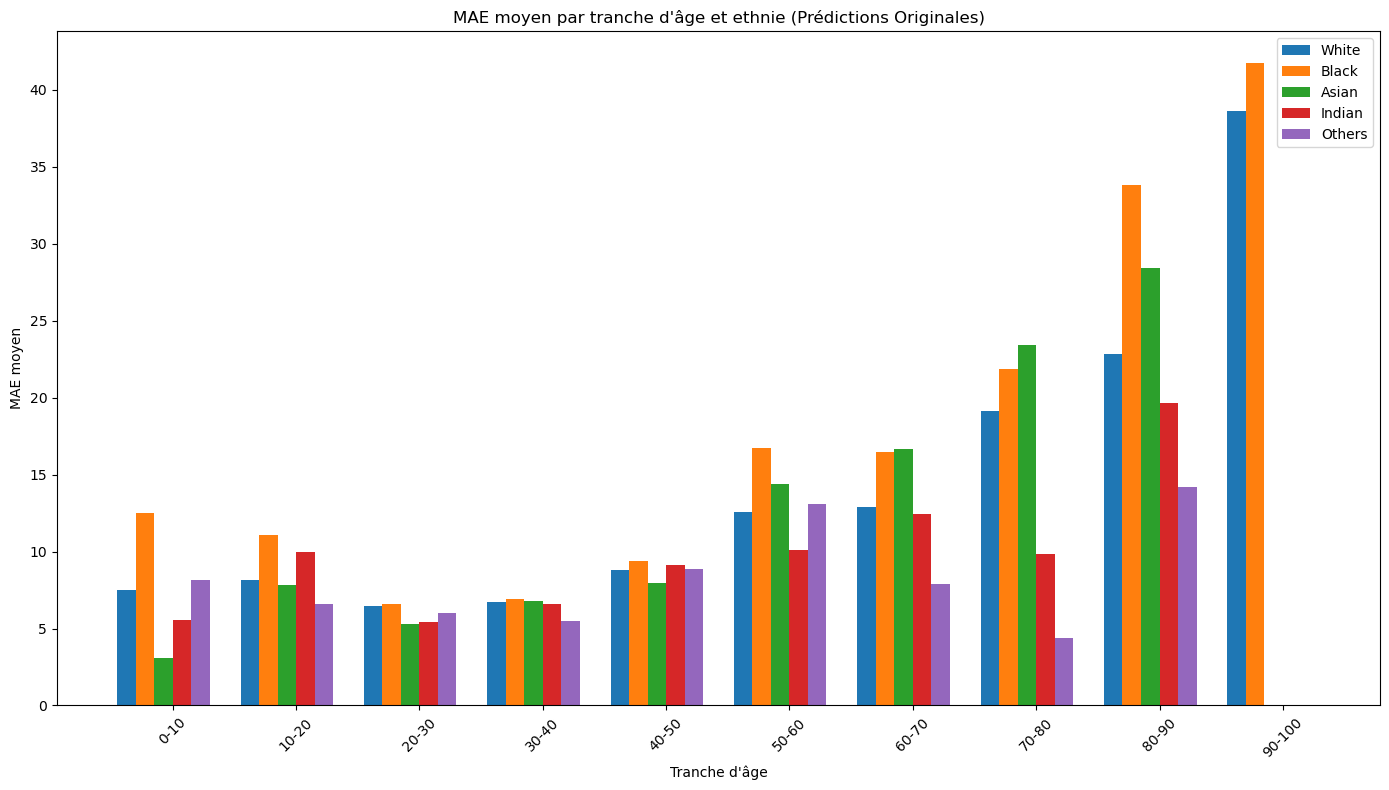

In [55]:
# Configuration des étiquettes pour les ethnies
ethnicity_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Configuration des tranches d'âge et des ethnies
age_bins = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
unique_ethnicities = np.unique(ethnicities_test)

# Initialisation de la structure pour stocker les erreurs
errors_per_age_ethnicity = {age: {eth: [] for eth in unique_ethnicities} for age in range(len(age_bins)-1)}

# Remplissage de la structure avec les erreurs absolues des prédictions
for i, age in enumerate(ages_test):
    age_index = np.digitize(age, age_bins) - 1
    age_index = min(age_index, len(age_bins) - 2)  # Gérer les âges à la limite supérieure
    ethnicity = ethnicities_test[i]
    prediction_error = abs(predicted_ages[i] - age)
    errors_per_age_ethnicity[age_index][ethnicity].append(prediction_error)

# Préparation des données pour le tracé
ages_to_plot = [f'{age_bins[i]}-{age_bins[i+1]}' for i in range(len(age_bins)-1)]
ethnicity_errors_to_plot = {eth: [] for eth in unique_ethnicities}

for age_index in errors_per_age_ethnicity:
    for eth in unique_ethnicities:
        errors = errors_per_age_ethnicity[age_index][eth]
        mae = np.mean(errors) if errors else 0
        ethnicity_errors_to_plot[eth].append(mae)

# Tracer l'histogramme double
bar_width = 0.15
index = np.arange(len(age_bins)-1)

fig, ax = plt.subplots(figsize=(14, 8))

# Ajouter les barres et utiliser les noms des ethnies pour la légende
bar_plots = []
for i, eth in enumerate(unique_ethnicities):
    bars = plt.bar(index + i * bar_width, ethnicity_errors_to_plot[eth], bar_width, label=ethnicity_labels[eth])
    bar_plots.append(bars)

plt.xlabel('Tranche d\'âge')
plt.ylabel('MAE moyen')
plt.title('MAE moyen par tranche d\'âge et ethnie (Prédictions Originales)')
plt.xticks(index + bar_width * (len(unique_ethnicities) / 2), ages_to_plot, rotation=45)

# Ajouter une légende qui utilise les noms des ethnies
ax.legend(bar_plots, [ethnicity_labels[eth] for eth in unique_ethnicities])

plt.tight_layout()
plt.show()


In [34]:
# Charge le meilleur modèle avec ses hyperparamètres
best_model = build_model_with_hyperparameters(best_hyperparameters, input_shape=(224, 224, 3))

# Gèle toutes les couches du modèle pré-entraîné sauf la dernière
for layer in best_model.layers[:-1]:
    layer.trainable = False

# Prépare la nouvelle entrée pour les données supplémentaires (genre et ethnie)
additional_features_input = Input(shape=(2,))  # 2 pour genre et ethnie

# Concatène la sortie de l'avant-dernière couche du modèle pré-entraîné avec les nouvelles entrées
concatenated = concatenate([best_model.layers[-2].output, additional_features_input])

# Ajoute une nouvelle couche Dense pour prédire l'âge
new_predictions = Dense(1, activation='linear')(concatenated)

# Construis le nouveau modèle en veillant à ne pas emballer 'base_model.input' dans une autre liste si c'est déjà une liste
model_inputs = [best_model.input, additional_features_input] if not isinstance(best_model.input, list) else best_model.input + [additional_features_input]

# Crée le nouveau modèle fine-tuné
fine_tuned_model = Model(inputs=model_inputs, outputs=new_predictions)

# Compile le nouveau modèle fine-tuné
fine_tuned_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Affiche le résumé pour vérifier
fine_tuned_model.summary()

# Maintenant, tu peux entraîner le modèle fine-tuné avec la nouvelle couche en utilisant les données d'image et les données supplémentaires
# Note: Assure-toi que 'additional_train_data' et 'additional_test_data' sont bien préparés avant de commencer l'entraînement


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 37,309,379 (142.32 MB)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 37,309,248 (142.32 MB)

In [35]:
# Préparation des données supplémentaires pour l'entraînement et le test
additional_train_data = np.hstack((genders_train.reshape(-1, 1), ethnicities_train.reshape(-1, 1)))
additional_test_data = np.hstack((genders_test.reshape(-1, 1), ethnicities_test.reshape(-1, 1)))

# Ré-entraînement du modèle avec les étiquettes (les âges) et les nouvelles entrées (images, genre et ethnie)
fine_tuning_history = fine_tuned_model.fit(
    [images_train, additional_train_data],
    ages_train,
    validation_data=([images_test, additional_test_data], ages_test),
    epochs=10,  # Le nombre d'époques dépend de tes besoins et observations lors des précédents entraînements
    batch_size=32,  # La taille du batch peut varier en fonction de la taille de ta mémoire GPU
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Tu peux maintenant évaluer ton modèle fine-tuné sur l'ensemble de test pour voir si les performances se sont améliorées
fine_tuned_test_loss, fine_tuned_test_mae = fine_tuned_model.evaluate([images_test, additional_test_data], ages_test)
print(f'Test MAE après fine-tuning: {fine_tuned_test_mae}')

# Et également faire des prédictions et les analyser si nécessaire
fine_tuned_predicted_ages = fine_tuned_model.predict([images_test, additional_test_data])


Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 5092s 9s/step - loss: 820.0313 - mae: 22.5802 - val_loss: 510.2600 - val_mae: 17.4170
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 5714s 10s/step - loss: 590.6592 - mae: 18.8206 - val_loss: 488.1939 - val_mae: 17.0095
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 1849s 3s/step - loss: 577.4755 - mae: 18.6410 - val_loss: 473.8168 - val_mae: 16.7367
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - loss: 558.3093 - mae: 18.3707 - val_loss: 460.2172 - val_mae: 16.4746
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 1479s 3s/step - loss: 532.2081 - mae: 17.8773 - val_loss: 448.8547 - val_mae: 16.2478
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 1631s 3s/step - loss: 510.3700 - mae: 17.4731 - val_loss: 438.6458 - val_mae: 16.0437
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 1617s 3s/step - loss: 507.6019 - mae: 17.3985 - val_loss: 428.3449 - val_mae: 15.8416
Epoch 8/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 1637s 3s/step - loss: 500.6180 - mae: 17.2249 - val_loss: 423.4364 - val_mae:

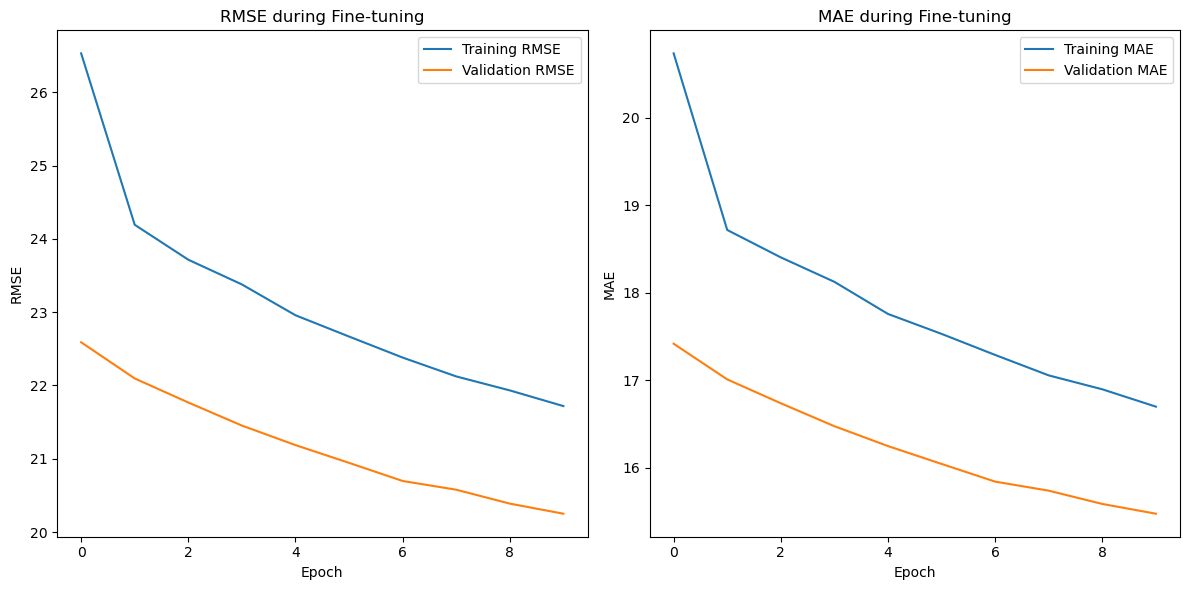

In [71]:
# Calcul du RMSE à partir de l'historique des pertes MSE
train_rmse = np.sqrt(np.array(fine_tuning_history.history['loss']))
val_rmse = np.sqrt(np.array(fine_tuning_history.history['val_loss']))

# Tracé des graphiques RMSE pour l'entraînement et la validation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Premier sous-graphique pour RMSE
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('RMSE during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# Utilisation directe des valeurs MAE de l'historique
train_mae = np.array(fine_tuning_history.history['mae'])
val_mae = np.array(fine_tuning_history.history['val_mae'])

# Tracé des graphiques MAE pour l'entraînement et la validation
plt.subplot(1, 2, 2)  # Second sous-graphique pour MAE
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('MAE during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour éviter les chevauchements
plt.show()


In [36]:
# Continue l'entraînement pour 5 époques supplémentaires
additional_epochs = 5
new_fine_tuning_history = fine_tuned_model.fit(
    [images_train, additional_train_data],
    ages_train,
    validation_data=([images_test, additional_test_data], ages_test),
    epochs=additional_epochs,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - loss: 475.4161 - mae: 16.7588 - val_loss: 405.9164 - val_mae: 15.3895
Epoch 2/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 854s 1s/step - loss: 467.7986 - mae: 16.6657 - val_loss: 401.5409 - val_mae: 15.3017
Epoch 3/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - loss: 457.9115 - mae: 16.4511 - val_loss: 397.9034 - val_mae: 15.2284
Epoch 4/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 793s 1s/step - loss: 454.7940 - mae: 16.4480 - val_loss: 396.0350 - val_mae: 15.1861
Epoch 5/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - loss: 435.2588 - mae: 16.0583 - val_loss: 393.7851 - val_mae: 15.1382


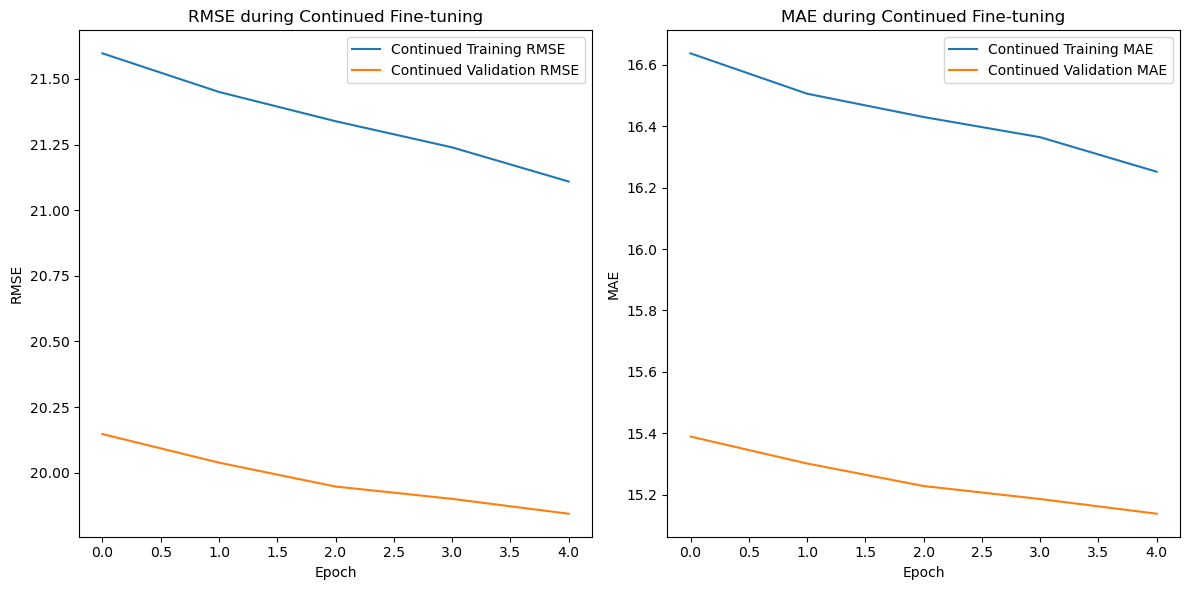

In [72]:
# Calcul du RMSE à partir de l'historique des pertes MSE pour les époques supplémentaires
continued_train_rmse = np.sqrt(np.array(new_fine_tuning_history.history['loss']))
continued_val_rmse = np.sqrt(np.array(new_fine_tuning_history.history['val_loss']))

# Tracé des graphiques RMSE pour l'entraînement et la validation continués
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Premier sous-graphique pour RMSE
plt.plot(continued_train_rmse, label='Continued Training RMSE')
plt.plot(continued_val_rmse, label='Continued Validation RMSE')
plt.title('RMSE during Continued Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# Utilisation directe des valeurs MAE de l'historique pour les époques supplémentaires
continued_train_mae = np.array(new_fine_tuning_history.history['mae'])
continued_val_mae = np.array(new_fine_tuning_history.history['val_mae'])

# Tracé des graphiques MAE pour l'entraînement et la validation continués
plt.subplot(1, 2, 2)  # Second sous-graphique pour MAE
plt.plot(continued_train_mae, label='Continued Training MAE')
plt.plot(continued_val_mae, label='Continued Validation MAE')
plt.title('MAE during Continued Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour éviter les chevauchements
plt.show()


In [37]:
# Continuer l'entraînement pour 10 époques supplémentaires
additional_epochs = 10
continued_fine_tuning_history = fine_tuned_model.fit(
    [images_train, additional_train_data],
    ages_train,
    validation_data=([images_test, additional_test_data], ages_test),
    epochs=additional_epochs,
    batch_size=32,  # Tu peux ajuster la taille du batch si nécessaire
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Évaluation du modèle après les époques supplémentaires
continued_fine_tuned_test_loss, continued_fine_tuned_test_mae = fine_tuned_model.evaluate(
    [images_test, additional_test_data], 
    ages_test
)
print(f'Test MAE après entraînement continué: {continued_fine_tuned_test_mae}')

# Tu peux ensuite faire des prédictions avec le modèle continué si nécessaire
continued_fine_tuned_predicted_ages = fine_tuned_model.predict([images_test, additional_test_data])


Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 772s 1s/step - loss: 443.3695 - mae: 16.2080 - val_loss: 389.8484 - val_mae: 15.0625
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 765s 1s/step - loss: 444.2207 - mae: 16.2322 - val_loss: 386.6845 - val_mae: 15.0024
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 815s 1s/step - loss: 435.4746 - mae: 16.0132 - val_loss: 387.2169 - val_mae: 15.0033
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - loss: 439.6452 - mae: 16.1288 - val_loss: 386.4672 - val_mae: 14.9863
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 840s 1s/step - loss: 439.2816 - mae: 16.1357 - val_loss: 385.8448 - val_mae: 14.9738
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 824s 1s/step - loss: 446.7758 - mae: 16.3311 - val_loss: 385.0816 - val_mae: 14.9540
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 806s 1s/step - loss: 429.9036 - mae: 15.9034 - val_loss: 382.3696 - val_mae: 14.9009
Epoch 8/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - loss: 435.9087 - mae: 16.1202 - val_loss: 379.9969 - val_mae: 14.8550


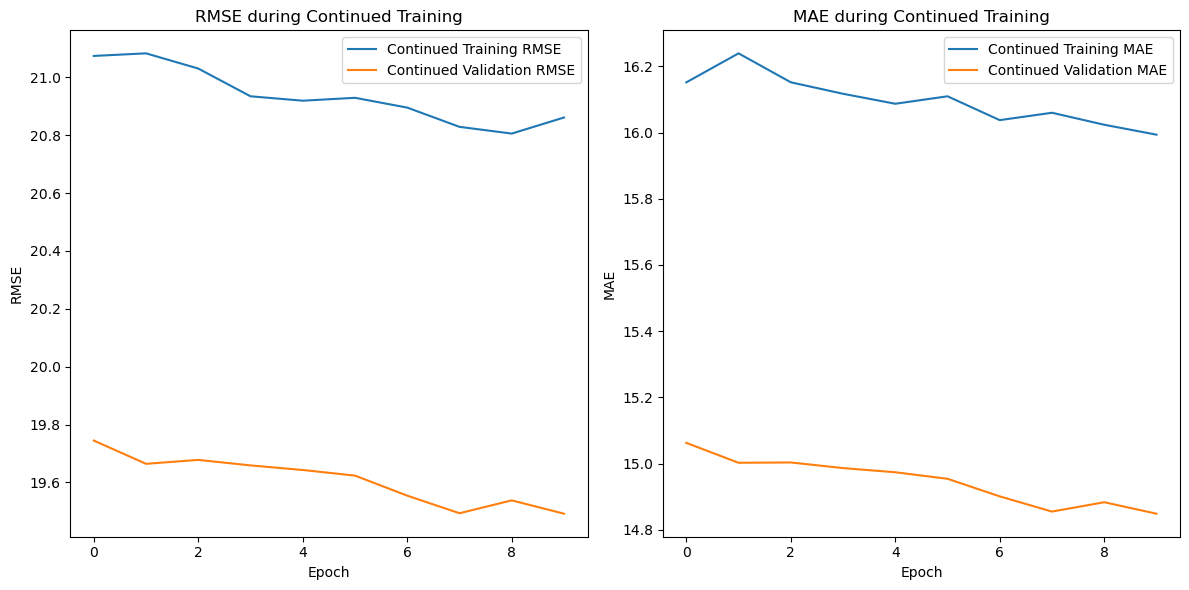

In [73]:
# Calcul du RMSE à partir de l'historique des pertes MSE pour les époques supplémentaires
continued_train_rmse = np.sqrt(np.array(continued_fine_tuning_history.history['loss']))
continued_val_rmse = np.sqrt(np.array(continued_fine_tuning_history.history['val_loss']))

# Tracé des graphiques RMSE pour l'entraînement et la validation continués
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Premier sous-graphique pour RMSE
plt.plot(continued_train_rmse, label='Continued Training RMSE')
plt.plot(continued_val_rmse, label='Continued Validation RMSE')
plt.title('RMSE during Continued Training')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# Utilisation directe des valeurs MAE de l'historique pour les époques supplémentaires
continued_train_mae = np.array(continued_fine_tuning_history.history['mae'])
continued_val_mae = np.array(continued_fine_tuning_history.history['val_mae'])

# Tracé des graphiques MAE pour l'entraînement et la validation continués
plt.subplot(1, 2, 2)  # Second sous-graphique pour MAE
plt.plot(continued_train_mae, label='Continued Training MAE')
plt.plot(continued_val_mae, label='Continued Validation MAE')
plt.title('MAE during Continued Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour éviter les chevauchements
plt.show()


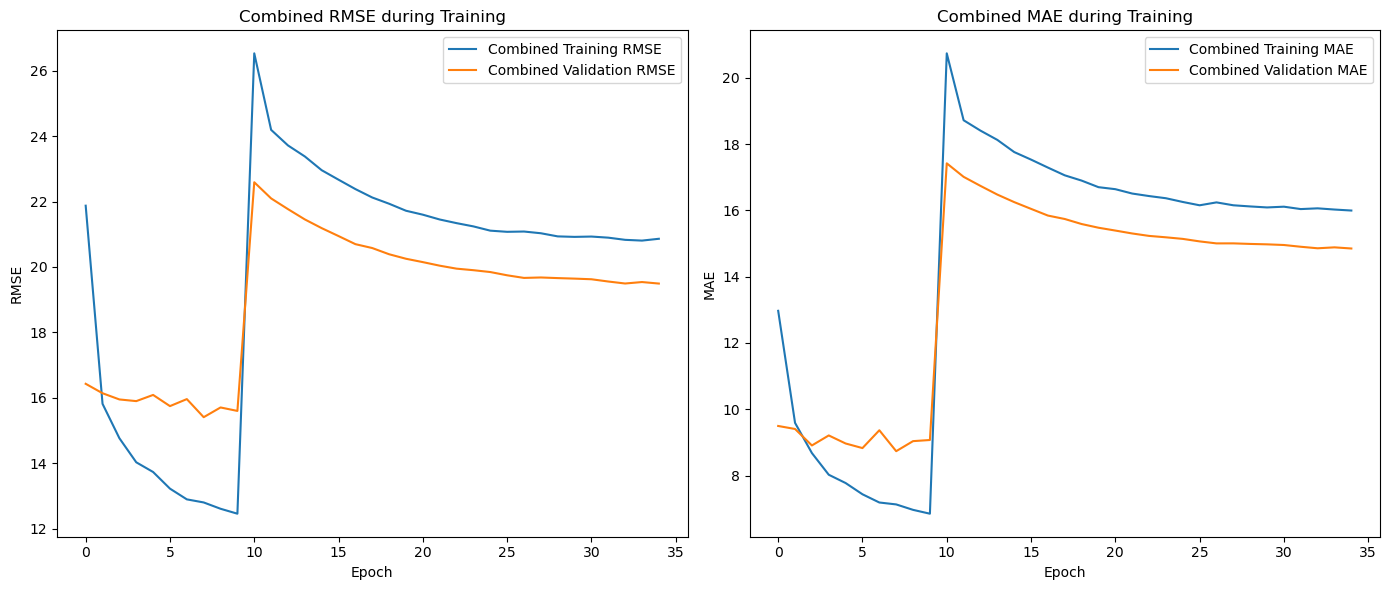

In [74]:
# Combinaison des historiques d'entraînement pour RMSE
combined_train_rmse = np.sqrt(np.concatenate([
    history.history['loss'],
    fine_tuning_history.history['loss'],
    new_fine_tuning_history.history['loss'],
    continued_fine_tuning_history.history['loss']
]))

combined_val_rmse = np.sqrt(np.concatenate([
    history.history['val_loss'],
    fine_tuning_history.history['val_loss'],
    new_fine_tuning_history.history['val_loss'],
    continued_fine_tuning_history.history['val_loss']
]))

# Combinaison des historiques d'entraînement pour MAE
combined_train_mae = np.concatenate([
    history.history['mae'],
    fine_tuning_history.history['mae'],
    new_fine_tuning_history.history['mae'],
    continued_fine_tuning_history.history['mae']
])

combined_val_mae = np.concatenate([
    history.history['val_mae'],
    fine_tuning_history.history['val_mae'],
    new_fine_tuning_history.history['val_mae'],
    continued_fine_tuning_history.history['val_mae']
])

# Tracé des graphiques combinés pour RMSE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # Sous-graphique pour RMSE
plt.plot(combined_train_rmse, label='Combined Training RMSE')
plt.plot(combined_val_rmse, label='Combined Validation RMSE')
plt.title('Combined RMSE during Training')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(1, 2, 2)  # Sous-graphique pour MAE
plt.plot(combined_train_mae, label='Combined Training MAE')
plt.plot(combined_val_mae, label='Combined Validation MAE')
plt.title('Combined MAE during Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


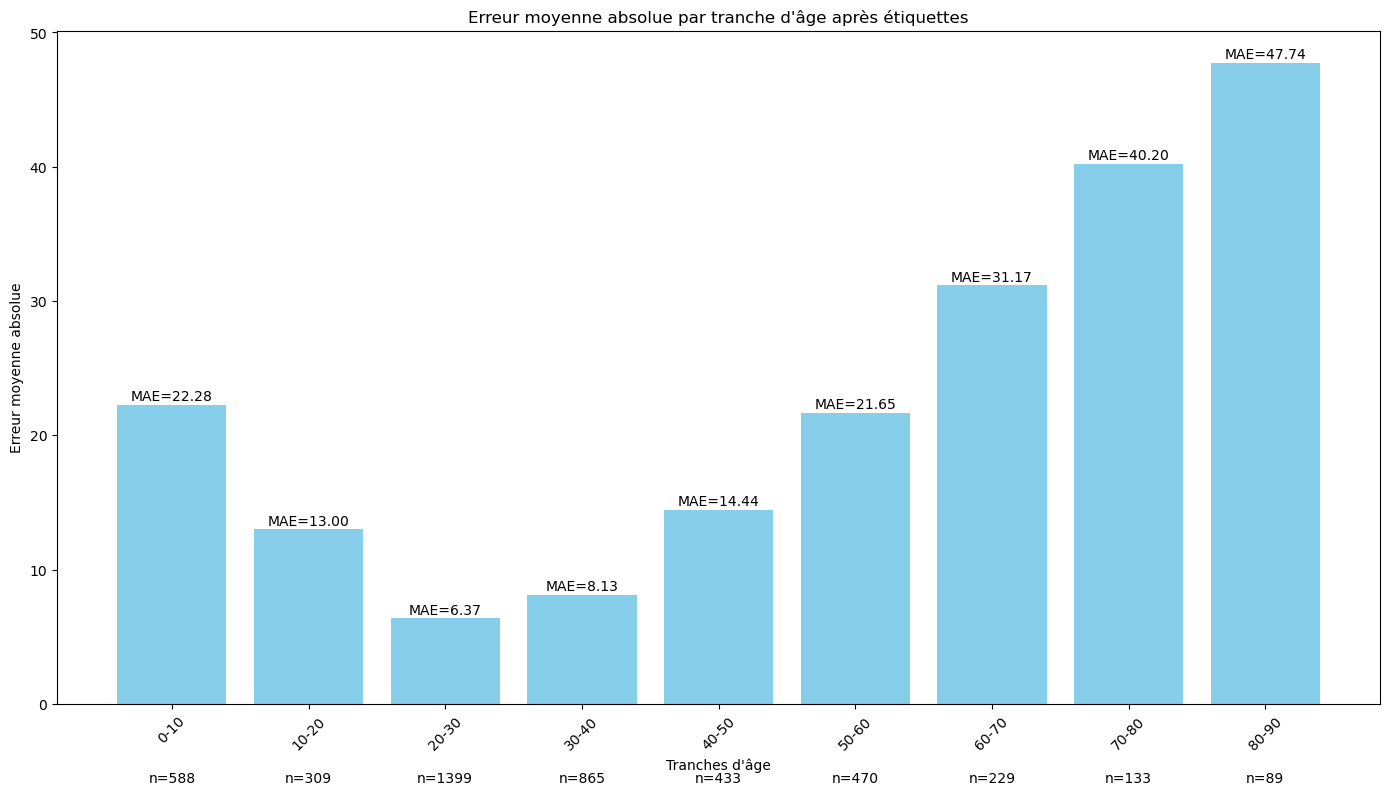

In [68]:
# Calculer les erreurs absolues entre les âges prédits et les vrais âges
absolute_errors = np.abs(continued_fine_tuned_predicted_ages.squeeze() - ages_test)

# Définir les tranches d'âge pour le graphique
age_bins = np.arange(0, 100, 10)  # Par exemple, tranches de 10 ans jusqu'à 100 ans
age_bin_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]

# Calculer le MAE par tranche d'âge
errors_per_age_bin = []
counts_per_age_bin = []
for i in range(len(age_bins)-1):
    bin_mask = (ages_test >= age_bins[i]) & (ages_test < age_bins[i+1])
    errors_per_age_bin.append(absolute_errors[bin_mask].mean() if bin_mask.any() else 0)
    counts_per_age_bin.append(bin_mask.sum())

# Créer le barplot
plt.figure(figsize=(14, 8))
bars = plt.bar(age_bin_labels, errors_per_age_bin, color='skyblue')

# Ajouter le nombre d'individus et le MAE moyen sur chaque barre
for bar, count, error in zip(bars, counts_per_age_bin, errors_per_age_bin):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, -5, f'n={count}', ha='center', va='top', color='black')
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f'MAE={error:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('Tranches d\'âge')
plt.ylabel('Erreur moyenne absolue')
plt.title('Erreur moyenne absolue par tranche d\'âge après étiquettes')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()



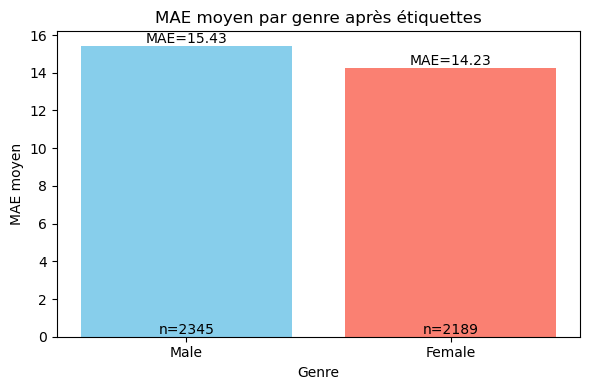

In [67]:
# Calcule le MAE pour chaque genre
unique_genders = np.unique(genders_test)  # unique_genders devrait être un tableau de toutes les valeurs uniques de genre dans l'ensemble de test
mae_per_gender = {}

for gender in unique_genders:
    indices = genders_test == gender  # Sélectionne les indices pour chaque genre
    errors = np.abs(ages_test[indices] - continued_fine_tuned_predicted_ages[indices].squeeze())  # Calcul des erreurs absolues
    mae_per_gender[gender] = np.mean(errors)  # Calcul du MAE

# Calcule le nombre d'individus par genre pour l'annotation
counts_per_gender = [(genders_test == g).sum() for g in unique_genders]

# Crée le barplot
plt.figure(figsize=(6, 4))
bars = plt.bar(unique_genders, list(mae_per_gender.values()), color=['skyblue', 'salmon'])

# Ajoute le nombre d'individus par genre sous les barres
for bar, count in zip(bars, counts_per_gender):
    plt.text(bar.get_x() + bar.get_width() / 2, 0, f'n={count}', ha='center', va='bottom', color='black', rotation=0)

# Ajoute le MAE moyen au-dessus de chaque barre
for bar, mae in zip(bars, list(mae_per_gender.values())):
    plt.text(bar.get_x() + bar.get_width() / 2, mae, f'MAE={mae:.2f}', ha='center', va='bottom', color='black')

# Définis les étiquettes de l'axe x comme 'Male' et 'Female' ou utilise les étiquettes existantes si elles sont différentes
plt.xticks(unique_genders, ['Male', 'Female'])  # Assure-toi de correspondre les étiquettes avec les valeurs dans unique_genders
plt.xlabel('Genre')
plt.ylabel('MAE moyen')
plt.title('MAE moyen par genre après étiquettes')
plt.tight_layout()
plt.show()


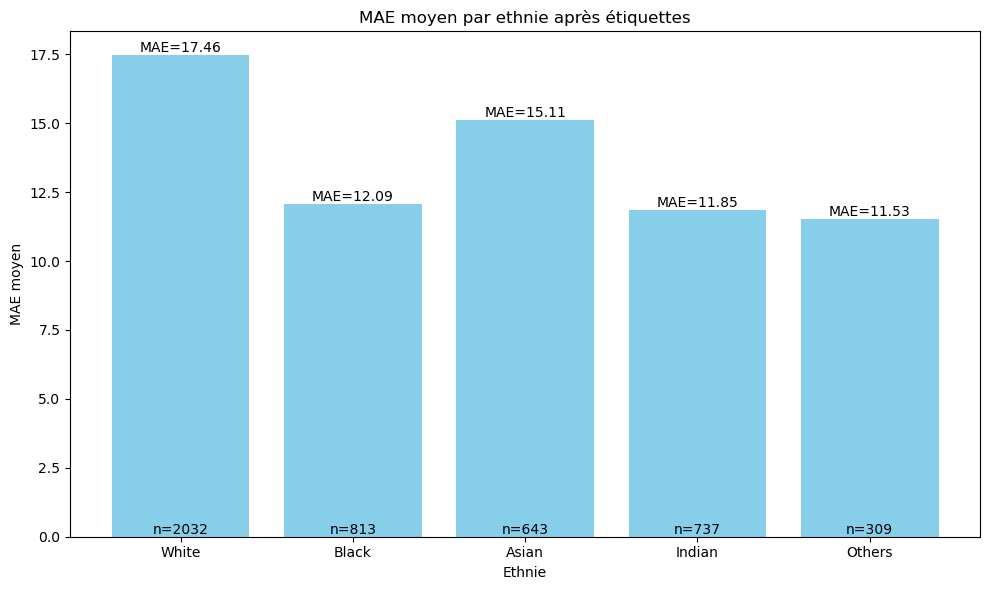

In [66]:
# On suppose que 'continued_fine_tuned_predicted_ages', 'ages_test', et 'ethnicities_test' sont déjà définis

# Dictionnaire pour renommer les valeurs d'ethnie
ethnicity_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Calcule le MAE pour chaque ethnie
unique_ethnicities = np.unique(ethnicities_test)  # unique_ethnicities devrait être un tableau de toutes les valeurs uniques d'ethnie dans l'ensemble de test
mae_per_ethnicity = {}

for ethnicity in unique_ethnicities:
    indices = ethnicities_test == ethnicity  # Sélectionne les indices pour chaque ethnie
    errors = np.abs(ages_test[indices] - continued_fine_tuned_predicted_ages[indices].squeeze())  # Calcul des erreurs absolues
    mae_per_ethnicity[ethnicity] = np.mean(errors)  # Calcul du MAE

# Calcule le nombre d'individus par ethnie pour l'annotation
counts_per_ethnicity = [(ethnicities_test == e).sum() for e in unique_ethnicities]

# Crée le barplot
plt.figure(figsize=(10, 6))
bars = plt.bar([ethnicity_labels[e] for e in unique_ethnicities], [mae_per_ethnicity[e] for e in unique_ethnicities], color='skyblue')

# Ajoute le nombre d'individus par ethnie sous les barres
for bar, count in zip(bars, counts_per_ethnicity):
    plt.text(bar.get_x() + bar.get_width() / 2, 0, f'n={count}', ha='center', va='bottom', color='black', rotation=0)

# Ajoute le MAE moyen au-dessus de chaque barre
for bar, mae in zip(bars, [mae_per_ethnicity[e] for e in unique_ethnicities]):
    plt.text(bar.get_x() + bar.get_width() / 2, mae, f'MAE={mae:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('Ethnie')
plt.ylabel('MAE moyen')
plt.title('MAE moyen par ethnie après étiquettes')
plt.tight_layout()
plt.show()


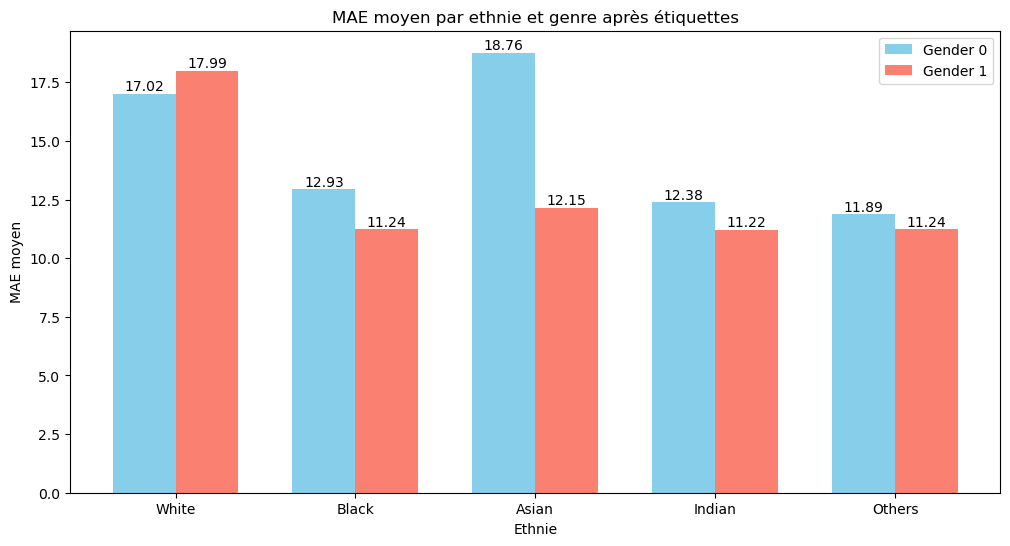

In [65]:
# Mettre en place les données
unique_ethnicities = np.unique(ethnicities_test)
unique_genders = np.unique(genders_test)

# Stocke le MAE pour chaque combinaison d'ethnie et de genre
mae_per_ethnicity_gender = {}

for ethnicity in unique_ethnicities:
    for gender in unique_genders:
        # Sélectionner les indices correspondant à l'ethnie et au genre courants
        indices = (ethnicities_test == ethnicity) & (genders_test == gender)
        # Calculer le MAE pour les indices sélectionnés
        errors = np.abs(ages_test[indices] - continued_fine_tuned_predicted_ages[indices].squeeze())
        mae_per_ethnicity_gender[(ethnicity, gender)] = errors.mean() if np.any(indices) else np.nan

# Tracer le graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Configuration des couleurs pour chaque genre
colors = ['skyblue', 'salmon']

# Tracer les barres
bar_width = 0.35
for i, gender in enumerate(unique_genders):
    mae_values = [mae_per_ethnicity_gender[(ethnicity, gender)] for ethnicity in unique_ethnicities]
    indices = np.arange(len(unique_ethnicities)) + i * bar_width
    ax.bar(indices, mae_values, bar_width, label=f'Gender {gender}', color=colors[i])

# Configuration des étiquettes et légendes de l'axe x
ax.set_xticks(np.arange(len(unique_ethnicities)) + bar_width / 2)
ax.set_xticklabels([ethnicity_labels[ethnicity] for ethnicity in unique_ethnicities])
ax.legend()

# Ajout des étiquettes de données
for ethnicity in unique_ethnicities:
    for gender in unique_genders:
        index = (ethnicity, gender)
        height = mae_per_ethnicity_gender[index]
        if not np.isnan(height):  # Vérifier que le MAE n'est pas NaN
            ax.text(ethnicity + (gender * bar_width), height, f'{height:.2f}', ha='center', va='bottom')

# Finaliser le graphique
ax.set_xlabel('Ethnie')
ax.set_ylabel('MAE moyen')
ax.set_title('MAE moyen par ethnie et genre après étiquettes')
plt.show()



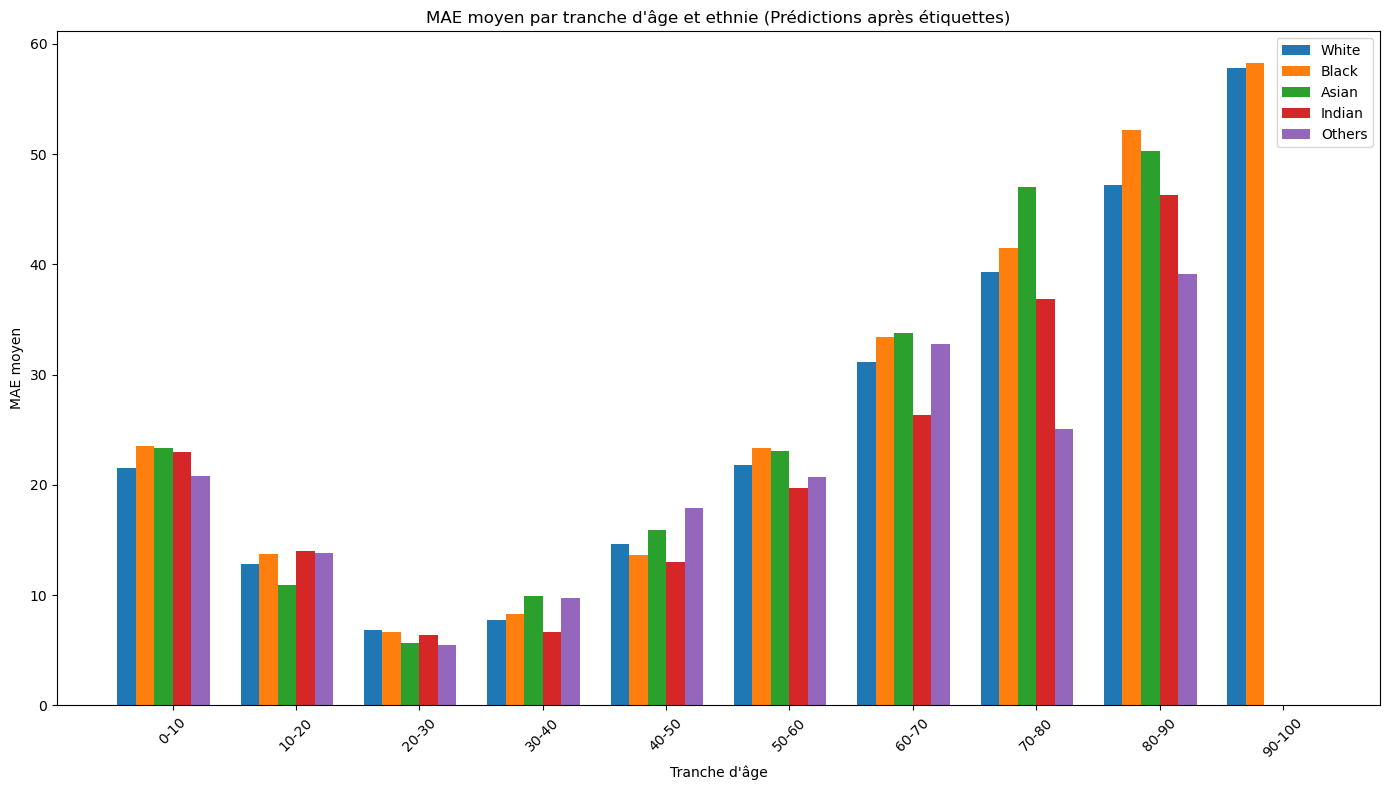

In [64]:
# Configuration des étiquettes pour les ethnies
ethnicity_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Configuration des tranches d'âge et des ethnies
age_bins = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
unique_ethnicities = np.unique(ethnicities_test)

# Initialisation de la structure pour stocker les erreurs
errors_per_age_ethnicity = {age: {eth: [] for eth in unique_ethnicities} for age in range(len(age_bins)-1)}

# Remplissage de la structure avec les erreurs absolues des prédictions fine-tunées
for i, age in enumerate(ages_test):
    age_index = np.digitize(age, age_bins) - 1
    age_index = min(age_index, len(age_bins) - 2)  # Gérer les âges à la limite supérieure
    ethnicity = ethnicities_test[i]
    prediction_error = abs(continued_fine_tuned_predicted_ages[i] - age)
    errors_per_age_ethnicity[age_index][ethnicity].append(prediction_error)

# Préparation des données pour le tracé
ages_to_plot = [f'{age_bins[i]}-{age_bins[i+1]}' for i in range(len(age_bins)-1)]
ethnicity_errors_to_plot = {eth: [] for eth in unique_ethnicities}

for age_index in errors_per_age_ethnicity:
    for eth in unique_ethnicities:
        errors = errors_per_age_ethnicity[age_index][eth]
        mae = np.mean(errors) if errors else 0
        ethnicity_errors_to_plot[eth].append(mae)

# Tracer l'histogramme double
bar_width = 0.15
index = np.arange(len(age_bins)-1)

fig, ax = plt.subplots(figsize=(14, 8))

# Ajouter les barres et utiliser les noms des ethnies pour la légende
bar_plots = []
for i, eth in enumerate(unique_ethnicities):
    bars = plt.bar(index + i * bar_width, ethnicity_errors_to_plot[eth], bar_width, label=ethnicity_labels[eth])
    bar_plots.append(bars)

plt.xlabel('Tranche d\'âge')
plt.ylabel('MAE moyen')
plt.title('MAE moyen par tranche d\'âge et ethnie (Prédictions après étiquettes)')
plt.xticks(index + bar_width * (len(unique_ethnicities) / 2), ages_to_plot, rotation=45)

# Ajouter une légende qui utilise les noms des ethnies
ax.legend(bar_plots, [ethnicity_labels[eth] for eth in unique_ethnicities])

plt.tight_layout()
plt.show()

